In [33]:
%matplotlib inline
import warnings
## scipy gives a waring when reading wav file
warnings.filterwarnings('ignore')

import scipy as sp
import scipy.io.wavfile
import scipy.signal
import numpy as np
from matplotlib import pyplot as plt

## Util functions

np.set_printoptions(suppress=True)

def todB(array):
    mean = np.mean(array)
    return 10 * np.log10(array / mean)

def plotSpectrogram(to_plot, yticks = np.array([]), cmap = plt.cm.gist_heat, subplot=111, _fig=False, fig_size=(15,7)):
    if (_fig == False):
        fig = plt.figure(figsize=fig_size)
    else:
        fig = _fig
    ax = fig.add_subplot(subplot)
    plt.imshow(to_plot, cmap=cmap)
    ax.set_aspect('auto')

    ## making pretty
    ax.set_ylim(ax.get_ylim()[::-1]) ## reversing axis
    plt.title("Spectrogram in the human hearing range")
    plt.xlabel("time (s)")
    plt.ylabel("frequency (Hz)")
    num_labels = 10
    xpoints = np.arange(to_plot.shape[1], step=int(to_plot.shape[1]/num_labels))
    plt.xticks(xpoints, np.round(t_points[xpoints], 1))
    if (yticks.size > 0):
        ypoints = np.arange(to_plot.shape[0], step=int(to_plot.shape[0]/num_labels))
        plt.yticks(ypoints, yticks[ypoints])
    plt.colorbar(orientation='vertical')
    return fig

def pol2cart(theta, rho):
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return np.array([x,y])

vpol2cart = np.vectorize(pol2cart)

def cartesian_coord(*arrays):
    grid = np.meshgrid(*arrays)        
    coord_list = [entry.ravel() for entry in grid]
    points = np.vstack(coord_list).T
    return points

In [2]:
# sample_rate, wav_data = scipy.io.wavfile.read("audio-files/kombucha.wav")
sample_rate, wav_data = sp.io.wavfile.read("audio-files/radiolab_crispr.wav")
# sample_rate, wav_data = sp.io.wavfile.read("audio-files/relief.wav")

## taking just one channel
mono_data = wav_data[:, 1]
audio_data = mono_data

start_point = 130 * sample_rate
end_point = 60 * sample_rate + start_point # in seconds
audio_data = audio_data[start_point:end_point]

print(len(mono_data), end_point)
    
segment_length = int(sample_rate/32)
overlap = int(segment_length / 2)
freq_points, t_points, spectrogram = scipy.signal.spectrogram(audio_data, nperseg=segment_length, fs=sample_rate,
                                  noverlap=overlap, mode="psd", nfft=sample_rate)

## just the human hearing range
spectrogram = spectrogram[0:1000, :]
print('done')

135921024 8379000
done


data space size 1000 by 3839 3839000


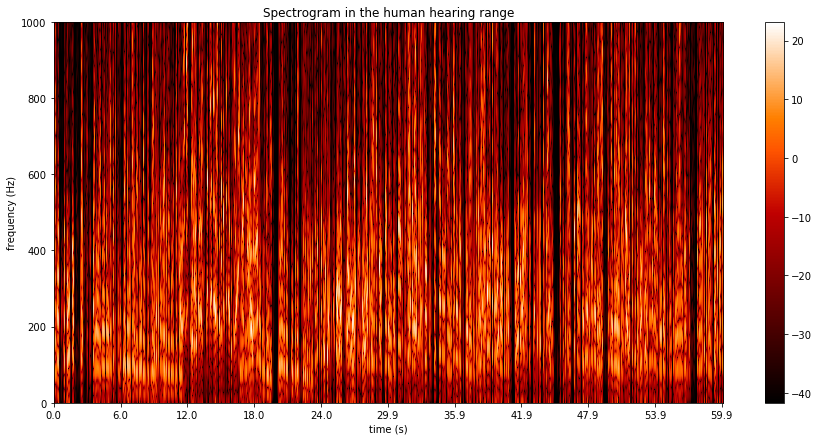

In [3]:
from matplotlib import pyplot as plt

specdb = todB(spectrogram + 1)
f = plotSpectrogram(specdb)

print("data space size", specdb.shape[0], "by", specdb.shape[1], specdb.shape[0] * specdb.shape[1], )

numpy.ndarray

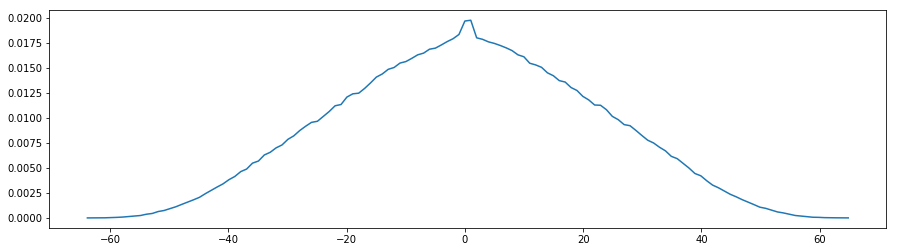

In [64]:
# if we were to take random points and get their diff, what would the distribution approach?
tests_per_vector = 1000000

xr = np.random.randint(0, specdb.shape[1], (tests_per_vector, 2))
yr = np.random.randint(0, specdb.shape[0], (tests_per_vector, 2))

pr = np.hstack((yr, xr))
diffs = specdb[pr[:,0], pr[:,2]] - specdb[pr[:,1], pr[:,3]]

mrange = np.max(specdb) - np.min(specdb)
base_hist, bin_edges = np.histogram(diffs, bins=int(np.ceil(mrange*2)), range=(-mrange, mrange), density=True)

fig = plt.figure(figsize=(15,4))
plt.plot(bin_edges[1:], base_hist)
# plt.vlines([-1,0,1], 0, np.max(h), linestyles="dotted")

type(base_hist)
type(bin_edges)

# print(diffs)

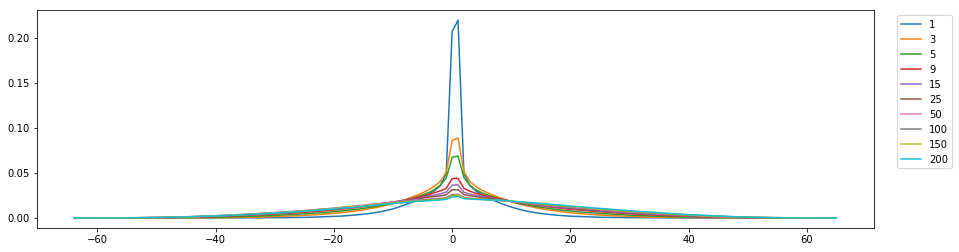

In [65]:
## what do the histograms look like for different jump steps
fig = plt.figure(figsize=(15,4))
tests_per_vector = 100000

# ra = np.random.rand(tests_per_vector) * np.pi
ra = np.arange(0, np.pi, np.pi / 32)
j = np.array([1, 3, 5, 9, 15, 25, 50, 100, 150, 200])
# ra = np.array([0, np.pi/2])
# j = np.array([1,5])

mra, mj = np.meshgrid(ra, j)
mra = np.ndarray.flatten(mra)
mj = np.ndarray.flatten(mj)

# print(np.rint(pol2cart(ra,1).T))
_cth = np.rint(pol2cart(mra, mj)).astype(int).T
_cth = np.array(np.split(_cth, j.shape[0])) # each block corresponds to a jump step

vfrand = np.vectorize(np.random.randint, otypes=[np.ndarray], excluded=["size"], signature="(),()->(m)")
for cth in _cth:
    # limits to starting positions
    l = np.empty((cth.shape[0], cth.shape[1], 2))
#     print(cth[:,0])
#     print((cth[:,0] >= 0).shape)
#     print(cth[:,0] >= 0)
#     print(specdb.shape[1])
    xaz = cth[:,0] >= 0
    xbz = cth[:,0] < 0
    l[xaz ,0,0] = 0
    l[xaz ,0,1] = specdb.shape[1] -cth[xaz,0] -1
    l[xbz ,0,0] = cth[xbz,0] * -1
    l[xbz ,0,1] = specdb.shape[1] - 1
    yaz = cth[:,1] >= 0
    ybz = cth[:,1] < 0
    l[yaz ,1,0] = 0
    l[yaz ,1,1] = specdb.shape[0] -cth[yaz,1] -1
    l[ybz ,1,0] = cth[ybz,1] * -1
    l[ybz ,1,1] = specdb.shape[0] - 1
    
#     print("\nLim\n", l)
#     print("\ncth", np.rint(cth))
    # starting positions
    xr = vfrand(l[:,0,0], l[:,0,1], size=tests_per_vector)
    yr = vfrand(l[:,1,0], l[:,1,1], size=tests_per_vector)
#     print(xr)
    xr = np.ndarray.flatten(xr.T).astype(int)
    yr = np.ndarray.flatten(yr.T).astype(int)
    # final positions
    c = np.tile(np.rint(cth), (tests_per_vector, 1))
#     print()
#     print(xr)
#     print(cth)
#     print()
#     print(c)
    c[:,0] = c[:,0] + xr
    c[:,1] = c[:,1] + yr
    c = np.array(c, dtype=int,copy=True)

#     print()
#     print(cth.shape)
#     print(c.shape)
#     print(xr.shape)
#     print("\nc\n", c)
    
    diffs = specdb[yr, xr] - specdb[c[:,1], c[:,0]]

    # histogram
#     vfhist = np.vectorize(np.histogram, otypes=[np.ndarray, np.ndarray], excluded=["bins", "range", "density"], signature="(m)->(),()")
    h,b = np.histogram(diffs, bins=int(np.ceil(mrange*2)), range=(-mrange, mrange), density=True)
    plt.plot(b[1:], h)
    
_discard = plt.legend(j, bbox_to_anchor=(1.10, 1))

In [33]:
# lets figure out using numerical methods the main edge types in the spectrogram

# the angles and jump magnitudes which we will study
angle_step = np.pi / 16
mag_step = 0.01
angles = np.arange(np.pi, step=angle_step)
jmsat = 1
jump_mag = 0.5 * specdb.shape[0] * np.power(np.arange(1, step=mag_step), 3) + jmsat
jump_mag = np.unique(np.rint(jump_mag))

# print(jump_mag)

test_vectors = cartesian_coord(angles, jump_mag)

test_mag_bounds = np.concatenate(([jmsat], jump_mag))
test_mag_bounds = np.diff(test_mag_bounds)
test_mag_bounds = np.reshape(np.concatenate((test_mag_bounds, jump_mag)), (2, jump_mag.shape[0])).T
test_mag_bounds = np.repeat(test_mag_bounds, repeats = angles.shape[0], axis=0)

# locations which are possible starting locations (high activation)
xp, yp = np.meshgrid(np.arange(specdb.shape[0]), np.arange(specdb.shape[1]))
test_start_locations = np.stack([xp, yp], axis = 2)
test_start_locations = np.reshape(test_start_locations, (xp.shape[0]*xp.shape[1], 2))
# print(test_start_locations[0:50])

tr_buff = np.empty((test_vectors.shape[0], 2))

# for i in np.arange(500, 550):
for i in np.arange(test_vectors.shape[0]):
# i = 52
    v = test_vectors[i]
    s_pos_rint = np.random.randint(0, test_start_locations.shape[0], size=tests_per_vector)
    s_pos = test_start_locations[s_pos_rint]
    r = np.random.rand(tests_per_vector, test_vectors.shape[1])
    vr = r
    # the angle can take any value between angles of neighbouring test vectors
    b = test_mag_bounds[i]
    vr[:, 0] = (vr[:, 0] * 2 - 1) * (angle_step) + v[0]
    vr[:, 1] = b[1] - vr[:, 1] * b[0]

    coord_th = np.rint([pol2cart(th, mag) for th, mag in vr]).astype(int)
    coord_th = coord_th[:, [1,0]]
    coord = (coord_th + s_pos)
    # making sure the index is not out of bounds
    coord_cond = (coord[:,0] < specdb.shape[0]) & (coord[:,0] >= 0) & (coord[:,1] < specdb.shape[1]) & (coord[:,1] >= 0)
    s_pos_res = s_pos[coord_cond]
    coord = coord[coord_cond]
    coord = coord.T
    
    s_pos_res = s_pos_res.T
    res = specdb[coord[0], coord[1]] - specdb[s_pos_res[0], s_pos_res[1]]
#     print(res)
    ## what shall we do about the abs / power?
    res_sum = np.sum(np.power(res, 2))
    tr_buff[i] = np.array([res_sum, res.shape[0]])

    
print("Test results")
print("test location sites: ", test_start_locations.shape[0])
print("data space size: ", specdb.shape)
print("test vectors number", test_vectors.shape[0])
np.set_printoptions(precision=2, suppress=True)
test_results = np.concatenate((test_vectors, tr_buff), axis=1)
test_results[:,0] = np.round(test_results[:,0] / np.pi, 2)
# print(test_results[0:50])

Test results
test location sites:  3837000
data space size:  (3000, 1279)
test vectors number 1440


11240363.7103


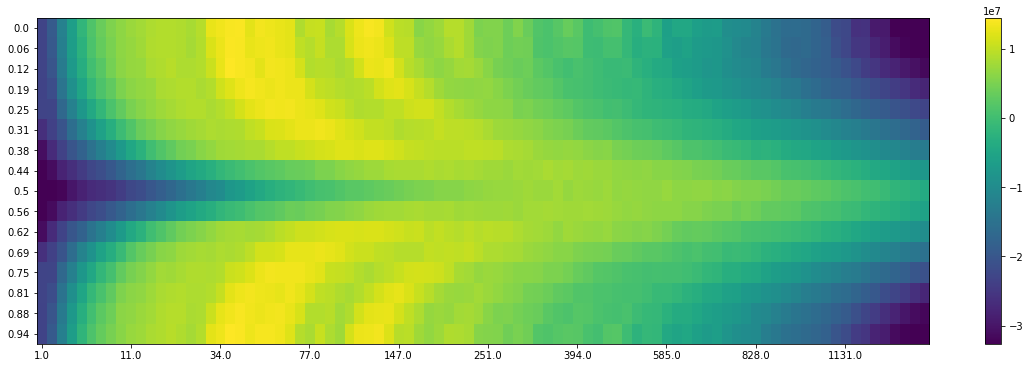

In [51]:
tr_plot = np.reshape(test_results[:,2], (jump_mag.shape[0], angles.shape[0]))
tr_plot = tr_plot - np.mean(tr_plot)

sd = np.std(tr_plot)
print(sd)
f = np.zeros(tr_plot.shape)
disp_cond = (tr_plot > sd*1) | (tr_plot < -sd*0.5)
f[disp_cond] = tr_plot[disp_cond]

fig = plt.figure(figsize=(20,6))
plt.imshow(f.T, aspect="auto")
plt.yticks(np.arange(angles.shape[0]), np.round(angles / np.pi, 2))
xtpos = np.arange(jump_mag.shape[0], step=int(jump_mag.shape[0]/10))
plt.xticks(xtpos, np.rint(jump_mag[xtpos]))
plt.colorbar(orientation='vertical')
